In [1]:
import torch
import torch.nn as nn

from torchvision import transforms

from PIL import Image

In [2]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-09-30 22:02:13--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPWItYU9oUktFMlVn [following]
--2021-09-30 22:02:13--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9

--2021-09-30 22:02:15--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/vgg_normalised.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWHp4QlpJMHNlQkZ1eHVjUWpsU2hCRUJ0TTdYNS1MbWotY2VxWjVGdTk2YWxBP3J0aW1lPU1vV3hoaEtFMlVn [following]
--2021-09-30 22:02:15--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/vgg_normalised.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb

 19200K .......... .......... .......... .......... .......... 24% 3.27M 6s
 19250K .......... .......... .......... .......... .......... 24% 2.05M 6s
 19300K .......... .......... .......... .......... .......... 24% 11.7M 6s
 19350K .......... .......... .......... .......... .......... 24% 9.21M 6s
 19400K .......... .......... .......... .......... .......... 24% 12.8M 6s
 19450K .......... .......... .......... .......... .......... 24% 86.3M 6s
 19500K .......... .......... .......... .......... .......... 24% 11.6M 6s
 19550K .......... .......... .......... .......... .......... 25% 11.2M 6s
 19600K .......... .......... .......... .......... .......... 25% 9.11M 6s
 19650K .......... .......... .......... .......... .......... 25% 14.0M 6s
 19700K .......... .......... .......... .......... .......... 25%  106M 6s
 19750K .......... .......... .......... .......... .......... 25% 2.87M 6s
 19800K .......... .......... .......... .......... .......... 25% 15.6M 6s
 19850K ....

In [3]:
import load_vgg_decoder

device = torch.device("cuda")

vgg, decoder = load_vgg_decoder.load(vgg_path="./vgg_normalised.pth", decoder_path="./decoder.pth", device=device)

In [4]:
def style_(feature, eps=1e-5):
    N, C = feature.size()[:2]
    
    feature = feature.reshape(N, C, -1)
    
    mean = feature.mean(dim=2).reshape(N, C, 1, 1)
    std = (feature.var(dim=2) + eps).sqrt().reshape(N, C, 1, 1)
    
    return mean, std

In [5]:
def adain_normalization(content_f, style_f):
    size = content_f.size()
    
    style_mean, style_std = style_(style_f)
    content_mean, content_std = style_(content_f)
    
    style_mean, style_std = style_mean.expand(size), style_std.expand(size)
    content_mean, content_std = content_mean.expand(size), content_std.expand(size)
    
    normalized_f = (content_f - content_mean) / content_std
    normalized_f = style_std * normalized_f + style_mean
    
    return normalized_f

In [6]:
def interpolation(content, styles, weights):
    content_f = vgg(content)
    style_fs = [vgg(style) for style in styles]
    
    feature = sum([weights[i] * adain_normalization(content_f, style_fs[i]) for i in range(len(style_fs))])
    
    return decoder(feature)

In [7]:
content_img = Image.open("./content.jpg").convert("RGB").resize((256, 256))
style_img = Image.open("./style_house.jpg").convert("RGB").resize((256, 256))

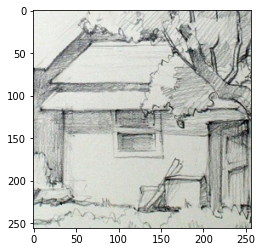

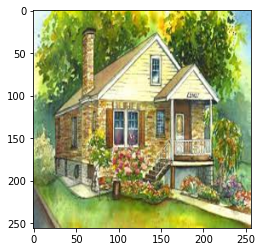

In [8]:
import matplotlib.pyplot as plt

plt.imshow(content_img)
plt.show()

plt.imshow(style_img)
plt.show()

In [9]:
def transform(size=128): return transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

content = transform(size=256)(content_img).to(device).unsqueeze(0)
style = transform(size=256)(style_img).to(device).unsqueeze(0)

coloring_result = interpolation(content, [style], [0.5])

c:\users\simplepro\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
import gc

torch.cuda.empty_cache()
gc.collect()

5972

In [11]:
coloring_result = coloring_result.cpu().detach().numpy()
print(coloring_result.shape)

(1, 3, 256, 256)


In [12]:
import numpy as np

coloring_result = coloring_result[0]

result = np.zeros((256, 256, 3))

for i in range(256):
    for j in range(256):
        result[i, j] = coloring_result[:, i, j]
        
print(result.shape)

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


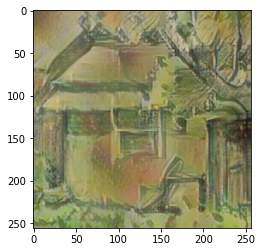

In [13]:
plt.imshow(result)

In [14]:
class AutoColoring:
    
    
    def __init__(self, content_path, style_paths, device, vgg, decoder, size, weights):
        self.content_img = Image.open(content_path).convert("RGB").resize(size)
        self.style_imgs = [Image.open(style_path).convert("RGB").resize(size) for style_path in style_paths]
        
        self.device = device
        self.vgg = vgg
        self.decoder = decoder
        self.size = size
        self.weights = weights
        
        
    def decode3shape(self, coloring_result):
        coloring_result = coloring_result[0]
        
        result = np.zeros((*self.size, 3))
        
        for i in range(self.size[0]):
            for j in range(self.size[0]):
                result[i, j] = coloring_result[:, i, j]
                
        return result
    
    
    def transform(self):
        return transforms.Compose([transforms.ToTensor()])
    
    
    def style_(self, feature, eps=1e-5):
        N, C = feature.size()[:2]

        feature = feature.reshape(N, C, -1)

        mean = feature.mean(dim=2).reshape(N, C, 1, 1)
        std = (feature.var(dim=2) + eps).sqrt().reshape(N, C, 1, 1)

        return mean, std
    
    
    def adain_normalization(self, content_f, style_f):
        size = content_f.size()

        style_mean, style_std = style_(style_f)
        content_mean, content_std = style_(content_f)

        style_mean, style_std = style_mean.expand(size), style_std.expand(size)
        content_mean, content_std = content_mean.expand(size), content_std.expand(size)

        normalized_f = (content_f - content_mean) / content_std
        normalized_f = style_std * normalized_f + style_mean

        return normalized_f
    
    
    def interpolation(self, content, styles):
        content_f = vgg(content)
        style_fs = [vgg(style) for style in styles]

        feature = sum([self.weights[i] * self.adain_normalization(content_f, style_fs[i]) for i in range(len(style_fs))])

        return decoder(feature)
    
    
    def result_(self):
        content = self.transform()(self.content_img).to(self.device).unsqueeze(0)
        styles = []
        for i in range(len(self.style_imgs)):
            styles.append(self.transform()(self.style_imgs[i]).to(self.device).unsqueeze(0))
            
        coloring_result = self.interpolation(content, styles)
                            
        torch.cuda.empty_cache()
        gc.collect()
                                        
        coloring_result = coloring_result.cpu().detach().numpy()
        
        coloring_result = self.decode3shape(coloring_result)
        
        return coloring_result

In [15]:
auto_coloring = AutoColoring(content_path="./content.jpg", style_paths=["./style_house.jpg"], device=device,
                            vgg=vgg, decoder=decoder, size=(256, 256), weights=[1.0])

coloring_result = auto_coloring.result_()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


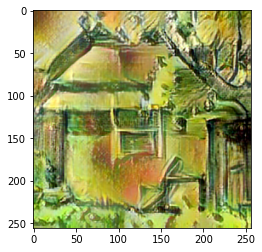

In [16]:
plt.imshow(coloring_result)

weight: 0.0


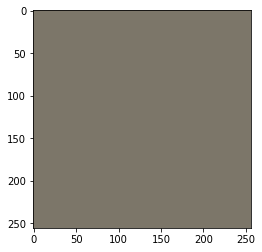

weight: 0.1


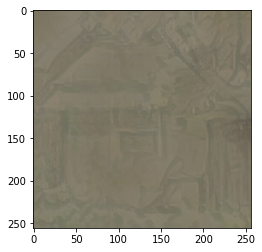

weight: 0.2


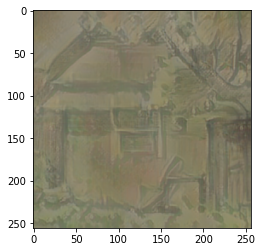

weight: 0.3


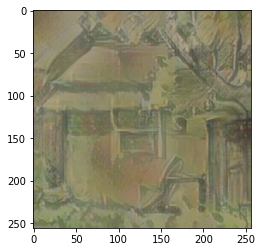

weight: 0.4


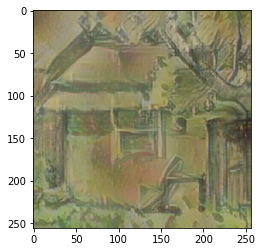

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weight: 0.5


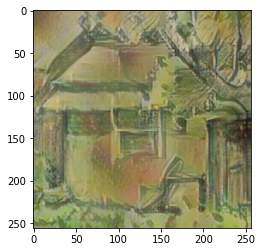

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weight: 0.6


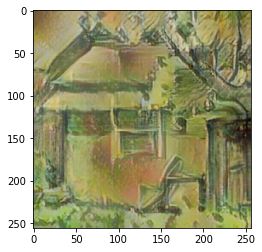

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weight: 0.7


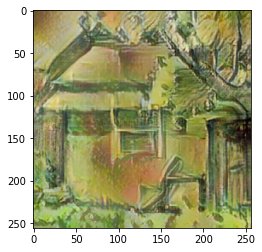

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weight: 0.8


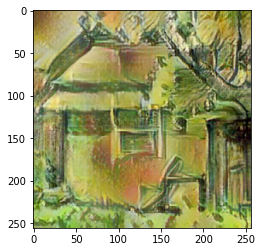

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weight: 0.9


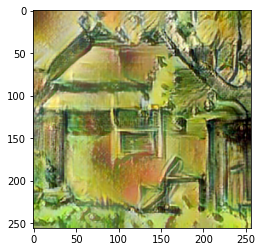

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weight: 1.0


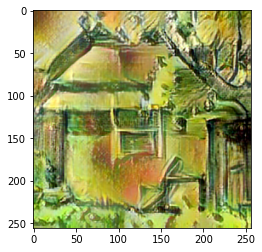

In [17]:
for i in range(11):
    auto_coloring = AutoColoring(content_path="./content.jpg", style_paths=["./style_house.jpg"], device=device, 
                                 vgg=vgg, decoder=decoder, size=(256, 256), weights=[i/10])

    coloring_result = auto_coloring.result_()
    
    print(f"weight: {i/10}")
    plt.imshow(coloring_result)
    plt.show()

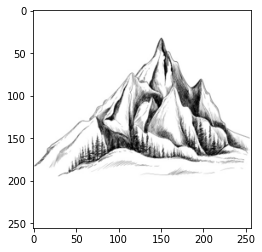

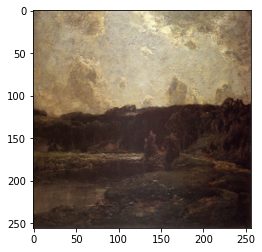

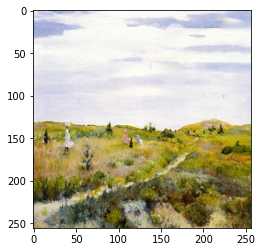

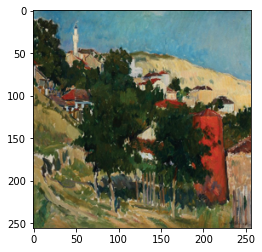

In [21]:
plt.imshow(Image.open("./content_mountain.jpg").convert("RGB").resize((256, 256)))
plt.show()

plt.imshow(Image.open("./style_mountain1.jpg").convert("RGB").resize((256, 256)))
plt.show()

plt.imshow(Image.open("./style_mountain2.jpg").convert("RGB").resize((256, 256)))
plt.show()

plt.imshow(Image.open("./style_mountain3.jpg").convert("RGB").resize((256, 256)))
plt.show()

In [22]:
auto_coloring = AutoColoring(content_path="./content_mountain.jpg", style_paths=["./style_mountain1.jpg", "./style_mountain2.jpg", "./style_mountain3.jpg"], device=device,
                            vgg=vgg, decoder=decoder, size=(256, 256), weights=[0.33, 0.33, 0.34])

coloring_result = auto_coloring.result_()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


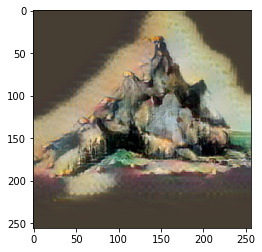

In [23]:
plt.imshow(coloring_result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [0.33, 0.33, 0.34]


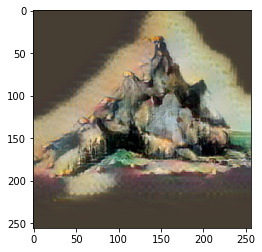

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [1.0, 0.0, 0.0]


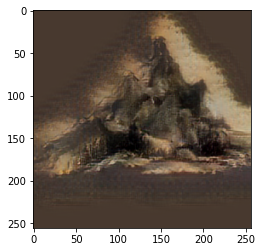

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [0.0, 1.0, 0.0]


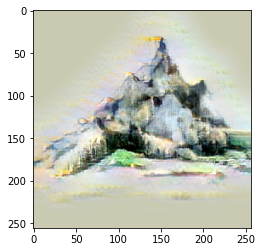

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [0.0, 0.0, 1.0]


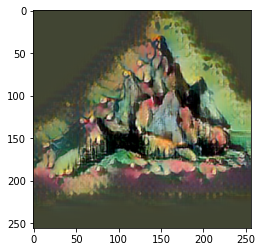

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [0.7, 0.15, 0.15]


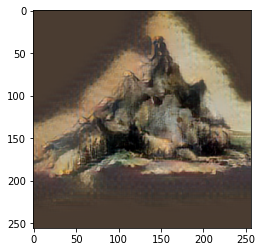

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [0.15, 0.7, 0.15]


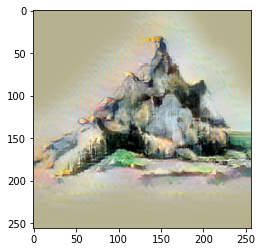

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


weights: [0.15, 0.15, 0.7]


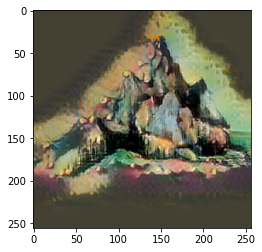

In [24]:
weights_list = [[0.33, 0.33, 0.34], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0],
                [0.7, 0.15, 0.15], [0.15, 0.7, 0.15], [0.15, 0.15, 0.7]]

for weights in weights_list:
    
    auto_coloring = AutoColoring(content_path="./content_mountain.jpg", style_paths=["./style_mountain1.jpg", "./style_mountain2.jpg", "./style_mountain3.jpg"], device=device,
                                vgg=vgg, decoder=decoder, size=(256, 256), weights=weights)

    coloring_result = auto_coloring.result_()
    
    print(f"weights: {weights}")
    plt.imshow(coloring_result)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


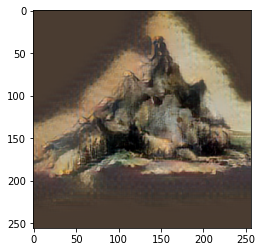

In [25]:
auto_coloring = AutoColoring(content_path="./content_mountain.jpg", style_paths=["./style_mountain1.jpg", "./style_mountain2.jpg", "./style_mountain3.jpg"], device=device,
                                vgg=vgg, decoder=decoder, size=(256, 256), weights=[0.7, 0.15, 0.15])

result = auto_coloring.result_()
plt.imshow(result)